In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import cv2
from torch import nn
import torch.nn.functional as F
from google.colab import drive


In [2]:
def load_images(image_size=600, batch_size=10, root="/content/drive/MyDrive/HackED2021/images"):
    transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    train_set = datasets.ImageFolder(root=root+"/train/", transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    test_set = datasets.ImageFolder(root=root+"/test/", transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    valid_set = datasets.ImageFolder(root=root+"/valid/", transform=transform)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True)



    return train_loader, valid_loader, test_loader

In [3]:
train_loader, valid_loader, test_loader = load_images()

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([10, 3, 128, 128])

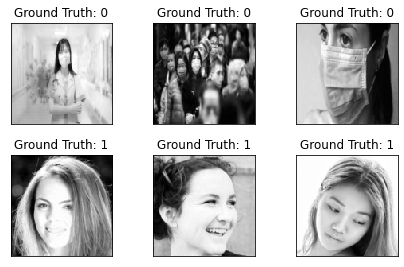

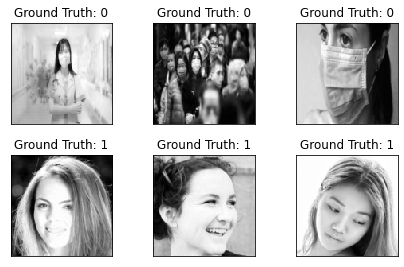

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap = "gray" ,interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
# This NN Architecture is implemented using 4 Convolution Layers and 4 Fully Connected Layer.
# It also uses Batch Normalization, 2 Dropout Regularization and 1 skip connection

class Net(nn.Module):
  def __init__(self):
        super(Net, self).__init__()
        # Transforms 3 x 128 x 128 to 8 x 124 x 124
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.dropout1 = nn.Dropout2d(0.5)

        # Transforms 32 x 124 x 124 to 64 x 120 x 120
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(64)

        # Transforms 64 x 60 x 60 to 128 x 60 x 60
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5)
        self.conv3_bn = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(100352, 1024)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc2_bn = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 2)

  def forward(self, x):
        # CONVNET
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # FC
        x = x.view(x.size(0), -1) # Flatten the image for Fully Connected Layer
        #print(x.shape)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout2(x)
        out = x.detach().clone()
        x = F.relu(self.fc2_bn(self.fc2(x)) + out) # Skip Connection
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x)

In [9]:
def train(trainloader, valid_dataloader, device, config):

  model = Net().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config['regular_constant'])  
  log_interval = 100

  best_correct = 0

  for epoch in range(1, config['num_epochs'] + 1):
    # Training

    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
      data = data.to(device)
      target = target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(trainloader.dataset),
          100. * batch_idx / len(trainloader), loss.item()))

    # Validation
      
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in valid_dataloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    validation_loss /= 298
    print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      validation_loss, correct, 298,
      100. * correct / 298))

    # Saving the model to be loaded for Testing
    if(correct > best_correct):
      best_correct = correct
      drive.mount('/content/drive/', force_remount=True)
      torch.save(model.state_dict(), './checkpointHackED2021/ckptFaceMask.pth')

  return model

In [7]:
def save_model_colab_for_submission(model):  # if you are running on colab
  drive.mount('/content/gdrive/', force_remount=True)
  torch.save(model.to(torch.device("cpu")), '/content/gdrive/My Drive/HackED2021/modelFaceMask.pt') # you will find the model in your home drive
  
def save_model_local_for_submission(model):  # if you are running on your local machine
  torch.save(model.to(torch.device("cpu")), 'modelFaceMask.pt')

In [10]:

config = {
      'lr': 0.001,
      'num_epochs': 20,
      'batch_size_train': 1,
      'batch_size_test': 10,
      'num_classes': 2,
      'momentum':0.5,
      'regular_constant':1e-5,
      }
  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#train_dataloader, valid_dataloader, test_dataloader = load_images()

model = train(train_loader, valid_loader, device, config)

# Testing and saving for submission
device = torch.device("cpu")

assert os.path.isdir('checkpointHackED2021'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./checkpointHackED2021/ckptFaceMask.pth')
model.load_state_dict(checkpoint)
model.eval()

save_model_colab_for_submission(model)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/768 (0%)]	Loss: 0.691282


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Avg. loss: 0.5018, Accuracy: 227/298 (76%)

Mounted at /content/drive/
Train Epoch: 2 [0/768 (0%)]	Loss: 0.360934

Validation set: Avg. loss: 0.3899, Accuracy: 252/298 (85%)

Mounted at /content/drive/
Train Epoch: 3 [0/768 (0%)]	Loss: 0.309875

Validation set: Avg. loss: 0.3714, Accuracy: 243/298 (82%)

Train Epoch: 4 [0/768 (0%)]	Loss: 0.398074

Validation set: Avg. loss: 0.2107, Accuracy: 283/298 (95%)

Mounted at /content/drive/
Train Epoch: 5 [0/768 (0%)]	Loss: 0.255293

Validation set: Avg. loss: 0.2870, Accuracy: 275/298 (92%)

Train Epoch: 6 [0/768 (0%)]	Loss: 0.157559

Validation set: Avg. loss: 0.2460, Accuracy: 270/298 (91%)

Train Epoch: 7 [0/768 (0%)]	Loss: 0.247202

Validation set: Avg. loss: 0.1253, Accuracy: 288/298 (97%)

Mounted at /content/drive/
Train Epoch: 8 [0/768 (0%)]	Loss: 0.161674

Validation set: Avg. loss: 0.0569, Accuracy: 296/298 (99%)

Mounted at /content/drive/
Train Epoch: 9 [0/768 (0%)]	Loss: 0.649336

Validation set: Avg. loss: 0.083